In [148]:
import numpy as np
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})

import scipy.linalg as spl
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
import xarray as xr

from waveeqn1D import WaveEquation

from utils import *
import nfft
import time

# Perturbation in $w$ (vertical velocity) as a function of a perturbation in $N$ (stratification)

The formula reads:

\begin{equation}
\delta w = \sum_n e^{ik_nx}\sum_l \left[e^{i\omega_{n,l}t}+e^{-i\omega_{n,l}t}\right] \left( \dfrac{\delta C_{n,l}}{2} \tilde w_{n,l} + \dfrac{C_{n,l}}{2} \delta\tilde w_{n,l}\right) + \left[e^{i\omega_{n,l}t}-e^{-i\omega_{n,l}t}\right] it~\dfrac{C_{n,l}}{2}\tilde w_{n,l} \delta \omega_{n,l}
\label{eqn:perturbation}
\end{equation}

Where 

\begin{align}
\delta C_{n,l} &= \left<\sum_{j\neq l} \dfrac{\tilde w_{n,j}^H\delta A_n^H ~\tilde v_{n,l}}{\lambda^*_{n,l} - \lambda^*_{n,j}} \tilde v_{n,j},\hat w_0(k_n,\cdot)\right>\\
\delta\tilde w_{n,l} &= \sum_{j\neq l}\dfrac{\tilde v_{n,j}^H~\delta A_n ~\tilde w_{n,l}}{\lambda_{n,l} - \lambda_{n,j}}\tilde w_{n,j}\\
\delta \omega_{n,l} &= (\tilde v_{n,l}^H ~\delta A_n ~\tilde w_{n,l}) \dfrac{\omega^3_{n,l}}{2k_n^2}\\
\end{align}

and 
\begin{equation}
\delta A_n = -\mathrm{diag}\left(\dfrac{2\delta N}{N^3}(z)\right)\left(\mathbf{D}_2 - k_n^2\mathbf{I}\right)
\end{equation}


In [86]:
# Wave equation class to act as a ground truth (w_perturbed - w_control)
class InternalWaveEquation:
    def __init__(self,Lx=10e3,Nx=1000,Lz=1e3,Nz=100,Lt=3600,Nt=60,z0=100,sigma_z=20):
        #x mesh
        self.L_x = Lx #Length of the domain in x [m]
        self.N_x = Nx #Number of points in x
        self.X = np.linspace(0,self.L_x,self.N_x)
        self.dx = self.X[1]-self.X[0] #horizontal discretization
        self.K = 2*np.pi*np.fft.fftfreq(self.N_x,self.dx)
        self.z0 = z0
        self.sigma_z = sigma_z
        
        #z mesh
        self.L_z = Lz #Depth of the domain [m]
        self.N_z = Nz #Number of points in z
        self.Z = np.linspace(0,self.L_z,self.N_z)
        self.dz = self.Z[1]-self.Z[0] #vertical discretization
        
        #Temporal mesh 
        self.L_t = Lt #Length of the integration
        self.N_t = Nt #Number of points in time
        self.T = np.linspace(0,self.L_t,self.N_t)
        self.dt = self.T[1]-self.T[0] #temporal discretization
        
    def I(self,x,z):
        x0=5e3;z0=200.
        zwidth=40
        xwidth=200
        return np.exp(-(z-z0)**2/2/zwidth**2-(x-x0)**2/2/xwidth**2)
        
    def N(self,z):
        return 0.01*z**0
        #return 0.01 + np.exp(-((z-self.z0)**2)/(2*self.sigma_z**2))*0.01
    
    def An(self,k):
        D2 = make_D_fornberg(self.Z,2,npoints=5)
        A = np.dot(np.diag(1/self.N(self.Z)**2),D2 - k**2*np.eye(self.N_z))
        A[0]=0.;A[0,0]=1.;A[-1]=0.;A[-1,-1]=1.
        return A
        
    def eigenmodes(self,k): 
        """Compute the eigenmodes w_tilde_kn and associated eigenvalues. Could be sped up with sparse matrices & selecting leading vertical modes only"""
        D2 = make_D_fornberg(self.Z,2,npoints=5)
        A = np.dot(np.diag(1/self.N(self.Z)**2),D2 - k**2*np.eye(self.N_z))
        
        A[0]=0.;A[0,0]=1.;A[-1]=0.;A[-1,-1]=1.
        
        lambdas,vtildes,wtildes=spl.eig(A,left=True) # The eigenvalues correspond to -omega^-2, where omega is the eigenfrequency of each mode
        sortidx = np.argsort(lambdas)
        cutoff=-2 # Throw away non-oscillatory modes
        lambdas = np.real(lambdas[sortidx[:cutoff]])
        vtildes = vtildes[:,sortidx[:cutoff]]
        wtildes = wtildes[:,sortidx[:cutoff]]
        
        #Normalize adjoint eigenvectors
        vtildes = vtildes/np.diagonal(np.dot(vtildes.transpose().conj(),wtildes))[None,:].conj()
        
        return (np.abs(k)/np.sqrt(-lambdas), # Vector of size N_z-2
                vtildes,
                wtildes         ) # Matrix of shape (N_z,N_x-2)
        
    def set_all_eigenmodes(self):
        self.vtildes = np.zeros((self.N_x,self.N_z-2,self.N_z)) # Dimensions: k,n,z
        self.wtildes = np.zeros((self.N_x,self.N_z-2,self.N_z)) # Dimensions: k,n,z
        self.omegas  = np.zeros((self.N_x,self.N_z-2))          # Dimensions: k,n
        for ik,k in enumerate(self.K):
            omegas,vtildes,wtildes = self.eigenmodes(k)
            self.vtildes[ik] = vtildes.transpose()
            self.wtildes[ik] = wtildes.transpose()
            self.omegas[ik]  = omegas
    
    def w0hat(self,ik):
        w0 = self.I(self.X[:,None],self.Z[None,:])
        return np.fft.fft(w0,axis=0)[ik]
        
    def integrate(self):
        %time self.set_all_eigenmodes()
        what = 1j*np.zeros((self.N_x,self.N_z,self.N_t))
        self.Cn = []
        for ik,k in enumerate(self.K):
            if ik == 0:
                continue
            # Get mode coefficients
            Cn = np.dot(self.vtildes[ik],self.w0hat(ik))
            self.Cn.append(Cn)
            # define evaluation points for the nonuniform inverse fft
            fk = self.omegas[ik]*self.dt/2/np.pi        
            
            # Perform the nonuniform inverse fft in time, grid point by grid point
            for iz in range(self.N_z):
                #what[ik,iz,0] =  (Cn*self.wtildes[ik,:,iz]).sum()
                what[ik,iz] =  nfft.nfft_adjoint(-fk, Cn/2*self.wtildes[ik,:,iz]*np.exp(-2*np.pi*1j*(self.N_t//2)*fk), self.N_t)
                what[ik,iz]+=  nfft.nfft_adjoint( fk, Cn/2*self.wtildes[ik,:,iz]*np.exp( 2*np.pi*1j*(self.N_t//2)*fk), self.N_t)
        self.Cn=np.array(self.Cn)   
        # Perform the inverse fft in x
        self.w = xr.DataArray(np.real(np.fft.ifft(what,axis=0)),coords={'x':self.X,'z':self.Z,'time':self.T},dims=['x','z','time'])
        self.w_init = xr.DataArray(self.I(self.X[:,None],self.Z[None,:]),coords={'x':self.X,'z':self.Z},dims=['x','z'])
        

In [170]:
# Main class to compute delta w
class PerturbationVelocity:
    def __init__(self,Lx=10e3,Nx=1000,Lz=1e3,Nz=100,Lt=3600,Nt=60,z0=100,sigma_z=20):
        #x mesh
        self.L_x = Lx #Length of the domain in x [m]
        self.N_x = Nx #Number of points in x
        self.X = np.linspace(0,self.L_x,self.N_x)
        self.dx = self.X[1]-self.X[0] #horizontal discretization
        self.K = 2*np.pi*np.fft.fftfreq(self.N_x,self.dx)
        self.z0 = z0
        self.sigma_z = sigma_z
        
        #z mesh
        self.L_z = Lz #Depth of the domain [m]
        self.N_z = Nz #Number of points in z
        self.Z = np.linspace(0,self.L_z,self.N_z)
        self.dz = self.Z[1]-self.Z[0] #vertical discretization
        
        #Temporal mesh 
        self.L_t = Lt #Length of the integration
        self.N_t = Nt #Number of points in time
        self.T = np.linspace(0,self.L_t,self.N_t)
        self.dt = self.T[1]-self.T[0] #temporal discretization
        
    def I(self,x,z):
        x0=5e3;z0=200.
        zwidth=40
        xwidth=200
        return np.exp(-(z-z0)**2/2/zwidth**2-(x-x0)**2/2/xwidth**2)
        
    def N(self,z):
        return 0.01*z**0
        #return 0.01 + np.exp(-((z-self.z0)**2)/(2*self.sigma_z**2))*0.01
    
    def deltaN(self,z):
        return np.exp(-((z-self.z0)**2)/(2*self.sigma_z**2))*1e-4
                
    def eigenmodes(self,k): 
        """Compute the eigenmodes w_tilde_kn and associated eigenvalues. Could be sped up with sparse matrices & selecting leading vertical modes only"""
        D2 = make_D_fornberg(self.Z,2,npoints=5)
        A = np.dot(np.diag(1/self.N(self.Z)**2),D2 - k**2*np.eye(self.N_z))
        
        A[0]=0.;A[0,0]=1.;A[-1]=0.;A[-1,-1]=1.
        
        lambdas,vtildes,wtildes=spl.eig(A,left=True) # The eigenvalues correspond to -omega^-2, where omega is the eigenfrequency of each mode
        sortidx = np.argsort(lambdas)
        cutoff=-2 # Throw away non-oscillatory modes
        lambdas = np.real(lambdas[sortidx[:cutoff]])
        vtildes = vtildes[:,sortidx[:cutoff]]
        wtildes = wtildes[:,sortidx[:cutoff]]
        
        #Normalize adjoint eigenvectors
        vtildes = vtildes/np.diagonal(np.dot(vtildes.transpose().conj(),wtildes))[None,:].conj()
        
        return (lambdas,
                np.abs(k)/np.sqrt(-lambdas), # Vector of size N_z-2
                vtildes,
                wtildes) # Matrix of shape (N_z,N_x-2)
        
    def set_all_eigenmodes(self):
        self.vtildes = np.zeros((self.N_x,self.N_z-2,self.N_z)) # Dimensions: k,n,z
        self.wtildes = np.zeros((self.N_x,self.N_z-2,self.N_z)) # Dimensions: k,n,z
        self.omegas  = np.zeros((self.N_x,self.N_z-2))          # Dimensions: k,n
        self.lambdas = np.zeros((self.N_x,self.N_z-2))          # Dimensions: k,n
        for ik,k in enumerate(self.K):
            lambdas,omegas,vtildes,wtildes = self.eigenmodes(k)
            self.vtildes[ik] = vtildes.transpose()
            self.wtildes[ik] = wtildes.transpose()
            self.omegas[ik]  = omegas
            self.lambdas[ik] = lambdas
    
    def w0hat(self,ik):
        w0 = self.I(self.X[:,None],self.Z[None,:])
        return np.fft.fft(w0,axis=0)[ik]
    
    def deltaAn(self,k):
        D2 = make_D_fornberg(self.Z,2,npoints=5)
        deltaAn = -np.dot(np.diag(2*self.deltaN(self.Z)/self.N(self.Z)**3),D2 - k**2*np.eye(self.N_z))
        deltaAn[0]=0.;deltaAn[-1]=0.
        return deltaAn
    
    def deltawtilde(self,ik,l,deltaAn):
        lambdas = self.lambdas[ik].copy()
        lambdas[l]=0 # dummy value to avoid dividing by 0
        fact= np.ones(self.N_z-2)
        fact[l]=0
        return ( (fact * np.dot( np.dot(self.vtildes[ik],deltaAn) , self.wtildes[ik,l] ) /(self.lambdas[ik,l]-lambdas))[:,None]*self.wtildes[ik]).sum(axis=0) 
   
    def deltavtilde(self,ik,l,deltaAn):
        lambdas = self.lambdas[ik].copy()
        lambdas[l]=0 # dummy value to avoid dividing by 0
        fact= np.ones(self.N_z-2)
        fact[l]=0
        return (fact[:,None]* np.dot( np.dot(self.wtildes[ik],deltaAn.T.conj()) , self.vtildes[ik,l] )[:,None] /(self.lambdas[ik,l].conj()-lambdas.conj())[:,None]*self.vtildes[ik]).sum(axis=0) 
    
    def deltaomega(self,ik,l,deltaAn):
        return np.dot( np.dot(self.vtildes[ik,l],deltaAn) , self.wtildes[ik,l] ) * self.omegas[ik,l]**3/2/self.K[ik]**2
        
    def compute_deltaw(self):
        %time self.set_all_eigenmodes()
        deltawhat = 1j*np.zeros((self.N_x,self.N_z,self.N_t))
        self.deltaCn=[]
        for ik,k in enumerate(self.K):
            if ik == 0:
                continue
            # Get mode coefficients
            Cn = np.dot(self.vtildes[ik],self.w0hat(ik))
            # Get perturbation variables
            deltaAn_ = self.deltaAn(k)
            deltaCn = np.array([np.dot(self.deltavtilde(ik,l,deltaAn_),self.w0hat(ik)) for l in range(self.N_z-2)])
            deltawntildes = np.array([self.deltawtilde(ik,l,deltaAn_) for l in range(self.N_z-2)])
            deltaomegans = np.array([self.deltaomega(ik,l,deltaAn_) for l in range(self.N_z-2)])
            self.deltaCn.append(deltaCn)
            # define evaluation points for the nonuniform inverse fft and temporal phase shift coefficients
            fk = self.omegas[ik]*self.dt/2/np.pi   
            phase_shift_minus = np.exp(-2*np.pi*1j*(self.N_t//2)*fk)
            phase_shift_plus  = np.exp( 2*np.pi*1j*(self.N_t//2)*fk)
            
            # Perform the nonuniform inverse fft in time, grid point by grid point
            for iz in range(self.N_z):
                deltawhat[ik,iz] =            nfft.nfft_adjoint(-fk, (Cn/2*deltawntildes[:,iz]+deltaCn/2*self.wtildes[ik,:,iz]) * phase_shift_minus, self.N_t)
                deltawhat[ik,iz]+=            nfft.nfft_adjoint( fk, (Cn/2*deltawntildes[:,iz]+deltaCn/2*self.wtildes[ik,:,iz]) * phase_shift_plus , self.N_t)
                deltawhat[ik,iz]-= 1j*self.T* nfft.nfft_adjoint(-fk, (Cn/2*self.wtildes[ik,:,iz]*deltaomegans) * phase_shift_minus, self.N_t)
                deltawhat[ik,iz]+= 1j*self.T* nfft.nfft_adjoint( fk, (Cn/2*self.wtildes[ik,:,iz]*deltaomegans) * phase_shift_plus , self.N_t)
     
        # Perform the inverse fft in x
        self.deltaw = xr.DataArray(np.real(np.fft.ifft(deltawhat,axis=0)),coords={'x':self.X,'z':self.Z,'time':self.T},dims=['x','z','time'])
        

# First test

In [167]:
# Compute delta w using perturbation theory
pvel = PerturbationVelocity(Lt=3000,Nt=100,Nx=100,Nz=50)
%time pvel.compute_deltaw()

CPU times: user 368 ms, sys: 14.3 ms, total: 382 ms
Wall time: 555 ms
CPU times: user 23.9 s, sys: 243 ms, total: 24.1 s
Wall time: 26.2 s


In [168]:
# Compute actual delta w

iwave = InternalWaveEquation(Lt=3000,Nt=100,Nx=100,Nz=50)

iwave_pert = InternalWaveEquation(Lt=3000,Nt=100,Nx=100,Nz=50)
iwave_pert.N = lambda z:0.01 + np.exp(-((z-iwave_pert.z0)**2)/(2*iwave_pert.sigma_z**2))*1e-4

iwave.integrate()
iwave_pert.integrate()

CPU times: user 353 ms, sys: 17.7 ms, total: 370 ms
Wall time: 397 ms
CPU times: user 233 ms, sys: 4.33 ms, total: 237 ms
Wall time: 238 ms


## Few checks

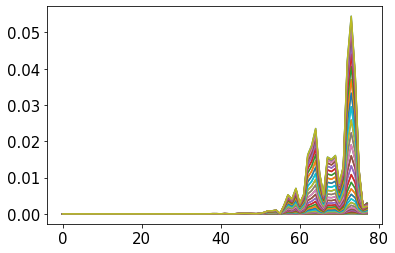

In [107]:
for i in range(99):
    plt.plot(np.abs(np.abs(iwave_pert.Cn[i])-np.abs(iwave.Cn[i])))

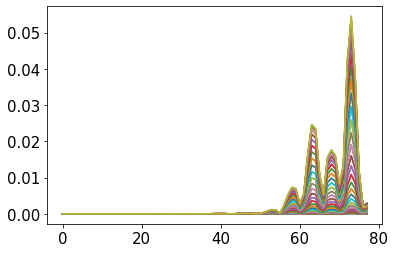

In [108]:
for i in range(99):
    plt.plot(np.abs(pvel.deltaCn[i]))

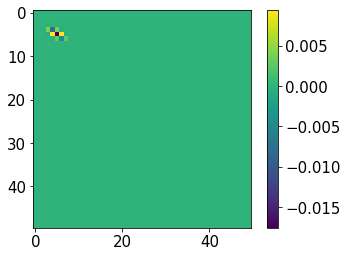

In [93]:
# Check that delta A_n is accurate
n0=3
k0 = iwave.K[n0]
im=plt.imshow(iwave_pert.An(k0)-iwave.An(k0) - pvel.deltaAn(k0))
plt.colorbar(im)

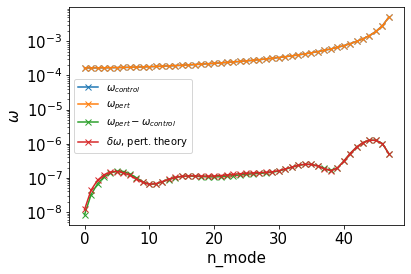

In [94]:
# Check that delta omega_n is accurate
deltaAn_ = pvel.deltaAn(pvel.K[n0])
plt.plot(iwave.omegas[n0] ,'-x',label=r'$\omega_{control}$')
plt.plot(iwave_pert.omegas[n0],'-x',label=r'$\omega_{pert}$')
plt.plot(iwave_pert.omegas[n0]-iwave.omegas[n0],'-x',label=r'$\omega_{pert}-\omega_{control}$')
plt.plot([pvel.deltaomega(3,l,deltaAn_) for l in range(48)],'-x',label=r'$\delta \omega$, pert. theory')
plt.yscale('log')
plt.xlabel('n_mode')
plt.ylabel(r'$\omega$')
plt.legend(fontsize=10)

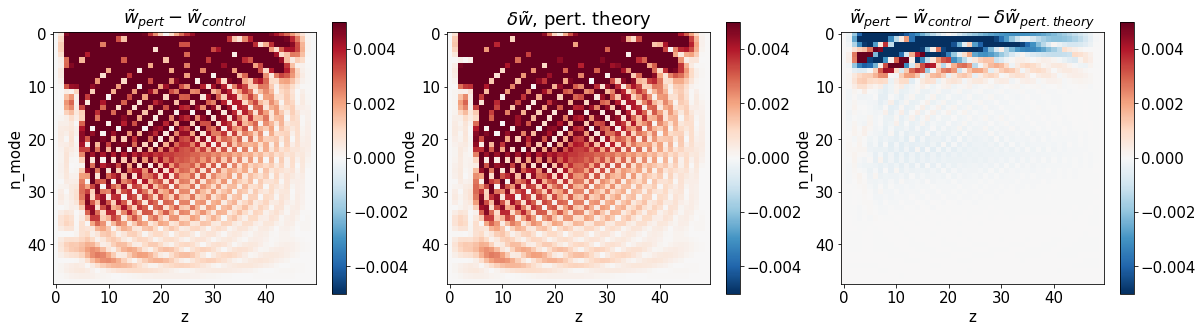

In [95]:
# Check that delta wtilde_n is accurate
# Need special care because the sign of the eigenvectors is set arbitrarily
# It is accurate in some regions (top right of the plot) but overall not so much
deltas = np.zeros((48,50))
for n in range(48):
    delta1 = iwave_pert.wtildes[3,n]-iwave.wtildes[3,n]
    delta2 = iwave_pert.wtildes[3,n]+iwave.wtildes[3,n]
    if spl.norm(delta1)<spl.norm(delta2):
        deltas[n]=delta1
    else:
        deltas[n]=delta2
        
fig,axs=plt.subplots(1,3,figsize=(20,5))
scale=5e-3
        
ax=axs[0]
im=ax.imshow(np.abs(deltas),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\tilde w_{pert} - \tilde w_{control}$')

deltaAn_ = pvel.deltaAn(pvel.K[n0])
deltas_analytical=np.array([pvel.deltawtilde(3,l,deltaAn_) for l in range(48)])
ax=axs[1]
im=ax.imshow(np.abs(deltas_analytical),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\delta \tilde w$, pert. theory')

ax=axs[2]
im=ax.imshow(np.abs(deltas)-np.abs(deltas_analytical),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\tilde w_{pert} - \tilde w_{control} - \delta \tilde w_{pert. theory}$')

for a in axs:
    a.set_xlabel("z")
    a.set_ylabel("n_mode")

(1000.0, 0.0)

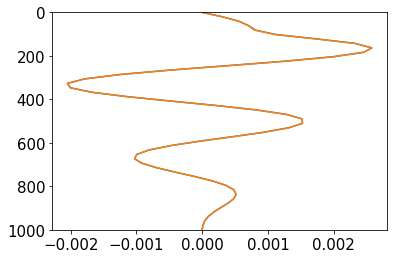

In [96]:
n=42
plt.plot(iwave_pert.wtildes[3,n]-iwave.wtildes[3,n],iwave_pert.Z)
plt.plot(pvel.deltawtilde(3,n,deltaAn_),pvel.Z)
#plt.plot(iwave.wtildes[3,n],iwave.Z)
#-iwave.wtildes[3,n]
plt.ylim(1000,0)

(1000.0, 0.0)

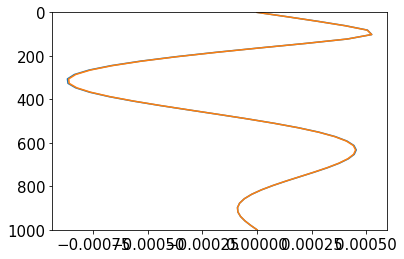

In [97]:
n=45
plt.plot(iwave_pert.wtildes[3,n]-iwave.wtildes[3,n],iwave_pert.Z)
plt.plot(pvel.deltawtilde(3,n,deltaAn_),pvel.Z)
#plt.plot(iwave.wtildes[3,n],iwave.Z)
#-iwave.wtildes[3,n]
plt.ylim(1000,0)

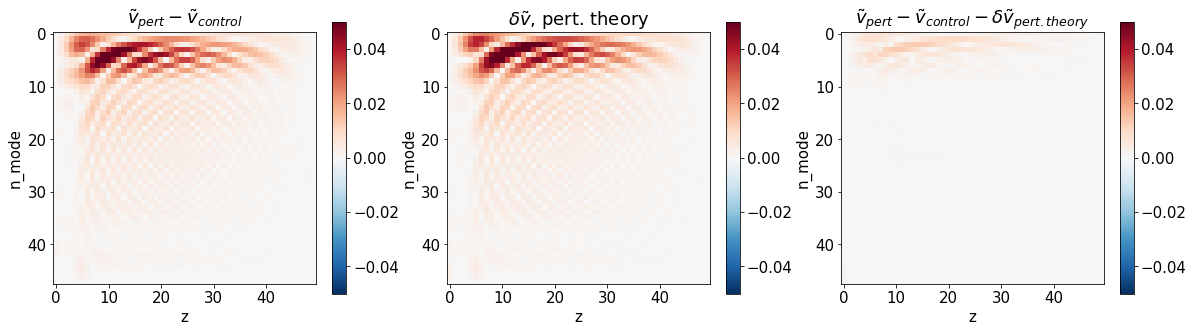

In [98]:
# Check that delta vtilde_n is accurate
# It is accurate in some regions (top right of the plot) but overall not so much
deltas = np.zeros((48,50))
for n in range(48):
    delta1 = iwave_pert.vtildes[3,n]-iwave.vtildes[3,n]
    delta2 = iwave_pert.vtildes[3,n]+iwave.vtildes[3,n]
    if spl.norm(delta1)<spl.norm(delta2):
        deltas[n]=delta1
    else:
        deltas[n]=delta2
        
fig,axs=plt.subplots(1,3,figsize=(20,5))
scale=5e-2
        
ax=axs[0]
im=ax.imshow(np.abs(deltas),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\tilde v_{pert} - \tilde v_{control}$')

deltaAn_ = pvel.deltaAn(pvel.K[n0])
deltas_analytical=np.array([pvel.deltavtilde(3,l,deltaAn_) for l in range(48)])
ax=axs[1]
im=ax.imshow(np.abs(deltas_analytical),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\delta \tilde v$, pert. theory')

ax=axs[2]
im=ax.imshow(np.abs(np.abs(deltas)-np.abs(deltas_analytical)),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\tilde v_{pert} - \tilde v_{control} - \delta \tilde v_{pert. theory}$')
for a in axs:
    a.set_xlabel("z")
    a.set_ylabel("n_mode")

## Comparing perturbation theory solution against ground truth

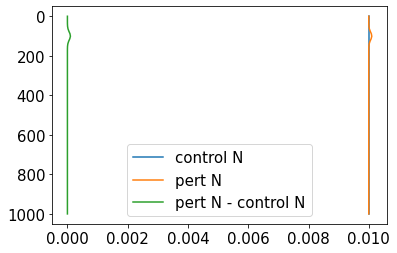

In [109]:
plt.plot(iwave.N(iwave.Z),iwave.Z,label='control N')
plt.plot(iwave_pert.N(iwave_pert.Z),iwave_pert.Z,label='pert N')
plt.plot(iwave_pert.N(iwave_pert.Z)-iwave.N(iwave.Z),iwave_pert.Z,label='pert N - control N')
plt.gca().invert_yaxis()
plt.legend()

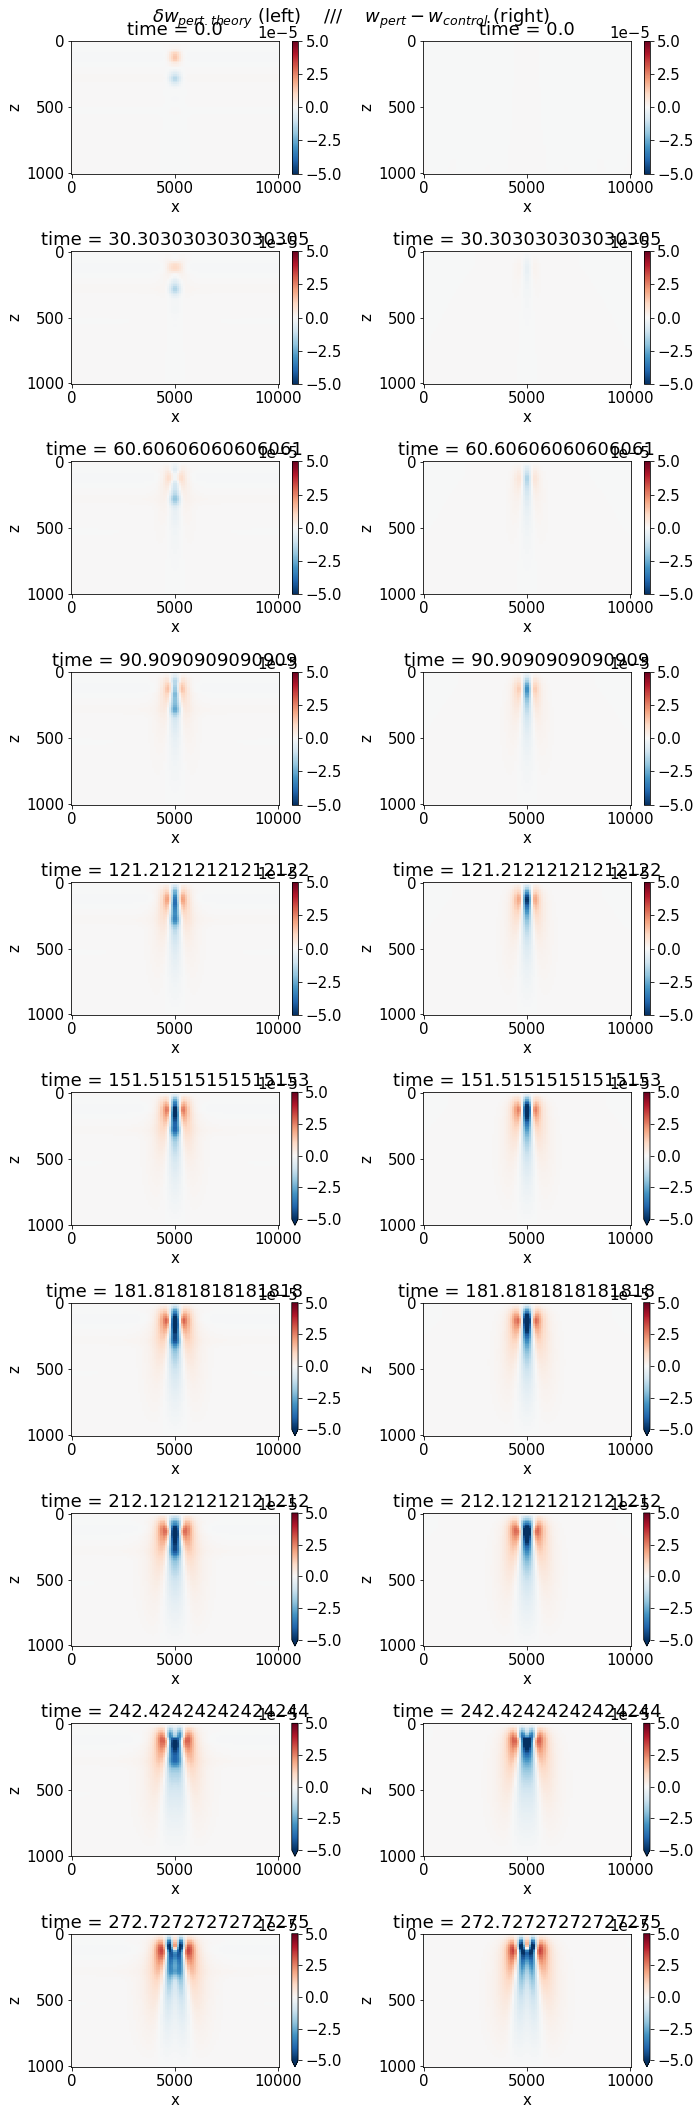

In [106]:
fig,ax=plt.subplots(10,2,figsize=(10,30))
scale=5e-5
for t in range(10):
    (pvel.deltaw.isel(time=t)).plot(ax=ax[t,0],y='z',yincrease=False,vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
    (iwave_pert.w.isel(time=t)-iwave.w.isel(time=t)).plot(ax=ax[t,1],y='z',yincrease=False,vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)

fig.suptitle(r"$\delta w_{pert. theory}$ (left)    ///    $w_{pert}-w_{control}$ (right)")
fig.tight_layout()

# Second test

In [176]:
Nbase_test = lambda z: 0.01 +  np.exp(-((z-iwave_pert.z0)**2)/(2*iwave_pert.sigma_z**2))*0.01
Npert_test = lambda z: 0.01 +  np.exp(-((z-iwave_pert.z0)**2)/(2*iwave_pert.sigma_z**2))*0.01 +  np.exp(-((z-iwave_pert.z0)**2)/(2*iwave_pert.sigma_z**2))*1e-4

In [177]:
# Compute delta w using perturbation theory
pvel = PerturbationVelocity(Lt=3000,Nt=100,Nx=100,Nz=50)
pvel.N=Nbase_test
%time pvel.compute_deltaw()

CPU times: user 389 ms, sys: 12.1 ms, total: 401 ms
Wall time: 442 ms
CPU times: user 25.3 s, sys: 197 ms, total: 25.5 s
Wall time: 27.4 s


In [178]:
# Compute actual delta w

iwave = InternalWaveEquation(Lt=3000,Nt=100,Nx=100,Nz=50)
iwave.N=Nbase_test

iwave_pert = InternalWaveEquation(Lt=3000,Nt=100,Nx=100,Nz=50)
iwave_pert.N = Npert_test

iwave.integrate()
iwave_pert.integrate()

CPU times: user 337 ms, sys: 5.38 ms, total: 342 ms
Wall time: 358 ms
CPU times: user 289 ms, sys: 1.23 ms, total: 290 ms
Wall time: 291 ms


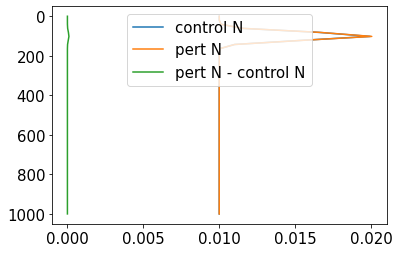

In [179]:
plt.plot(iwave.N(iwave.Z),iwave.Z,label='control N')
plt.plot(iwave_pert.N(iwave_pert.Z),iwave_pert.Z,label='pert N')
plt.plot(iwave_pert.N(iwave_pert.Z)-iwave.N(iwave.Z),iwave_pert.Z,label='pert N - control N')
plt.gca().invert_yaxis()
plt.legend()

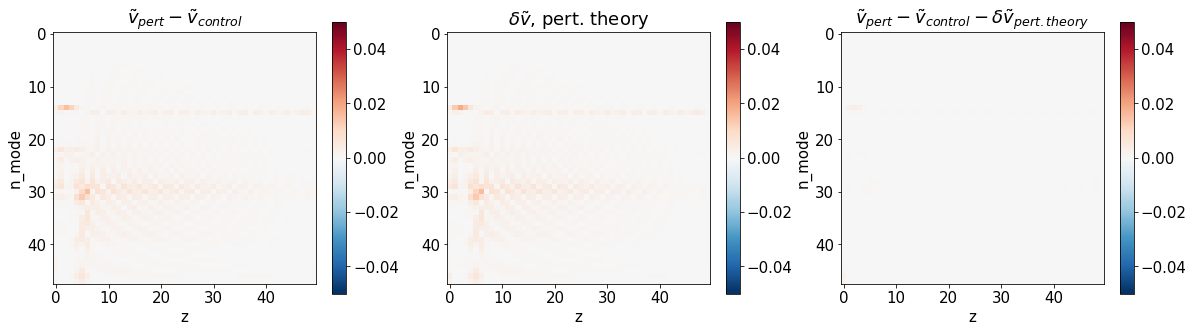

In [180]:
# Check that delta vtilde_n is accurate
# It is accurate in some regions (top right of the plot) but overall not so much
deltas = np.zeros((48,50))
for n in range(48):
    delta1 = iwave_pert.vtildes[3,n]-iwave.vtildes[3,n]
    delta2 = iwave_pert.vtildes[3,n]+iwave.vtildes[3,n]
    if spl.norm(delta1)<spl.norm(delta2):
        deltas[n]=delta1
    else:
        deltas[n]=delta2
        
fig,axs=plt.subplots(1,3,figsize=(20,5))
scale=5e-2
        
ax=axs[0]
im=ax.imshow(np.abs(deltas),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\tilde v_{pert} - \tilde v_{control}$')

deltaAn_ = pvel.deltaAn(pvel.K[n0])
deltas_analytical=np.array([pvel.deltavtilde(3,l,deltaAn_) for l in range(48)])
ax=axs[1]
im=ax.imshow(np.abs(deltas_analytical),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\delta \tilde v$, pert. theory')

ax=axs[2]
im=ax.imshow(np.abs(np.abs(deltas)-np.abs(deltas_analytical)),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\tilde v_{pert} - \tilde v_{control} - \delta \tilde v_{pert. theory}$')
for a in axs:
    a.set_xlabel("z")
    a.set_ylabel("n_mode")

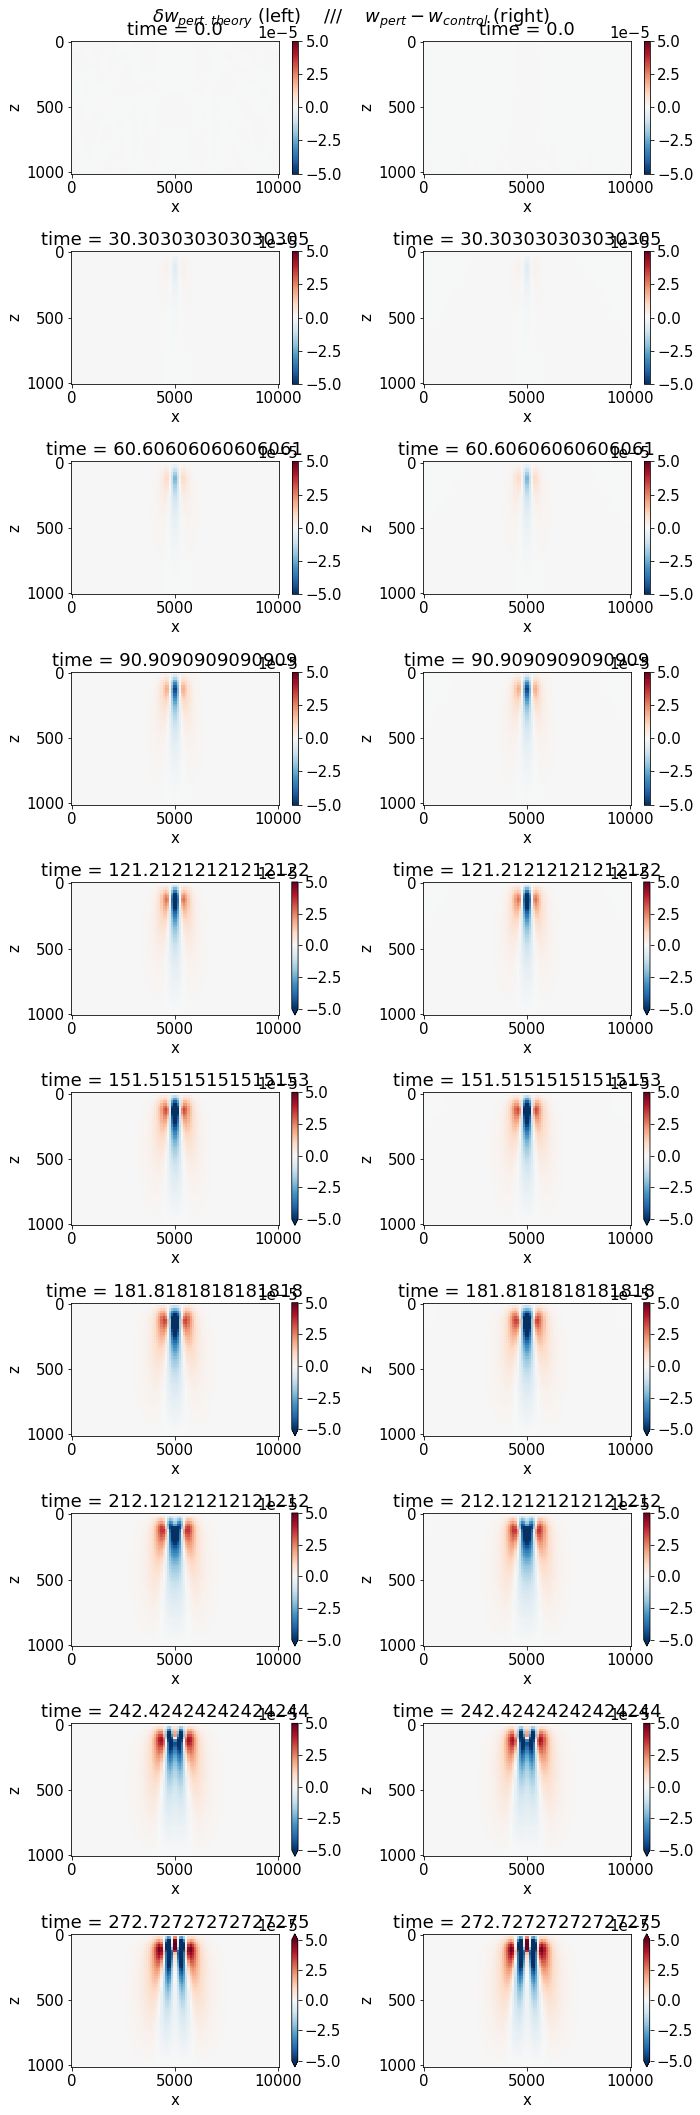

In [181]:
fig,ax=plt.subplots(10,2,figsize=(10,30))
scale=5e-5
for t in range(10):
    (pvel.deltaw.isel(time=t)).plot(ax=ax[t,0],y='z',yincrease=False,vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
    (iwave_pert.w.isel(time=t)-iwave.w.isel(time=t)).plot(ax=ax[t,1],y='z',yincrease=False,vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)

fig.suptitle(r"$\delta w_{pert. theory}$ (left)    ///    $w_{pert}-w_{control}$ (right)")
fig.tight_layout()